In [632]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


# 1. Загрузка данных

Импортируем необходимые библиотеки кроме уже загруженных и устанавливаем общие параметры

In [633]:
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 12})

TRAIN_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'
SUBMIT_PATH = '/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv'

In [634]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()


импортируем данные

In [635]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [636]:
train_df.info() #уже здесь видно, что есть пропуски в LifeSquare и Healthcare_1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [637]:
test_df = pd.read_csv(TEST_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


Приведение типов 

Убираем из вещественных признаков категориальные Id и DistrictId - меняем на строковый формат

In [638]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [639]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# 2. EDA

Смотрим на целевую переменную

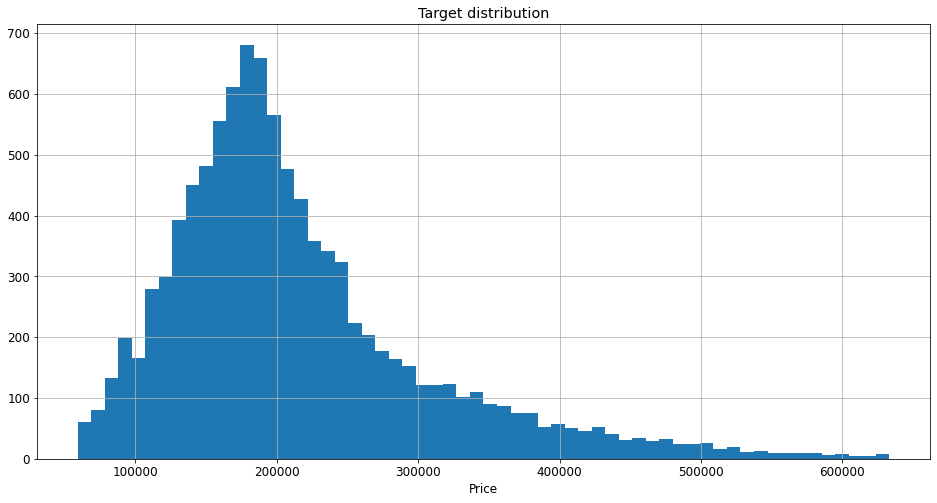

In [640]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=60)
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

смотрим общие метрики

In [641]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Аналогично видны пропуски в данных по LifeSquare и Healthcare_1
Видны выбросы в части нулевых значений Rooms, HouseFloor, KitchenSquare и очень маленьких или слишком больших значений в Square, LifeSquare, KitchenSquare.
Видно, что среднее значение HouseYear значительно больше медианы, что говорит о выбросе.

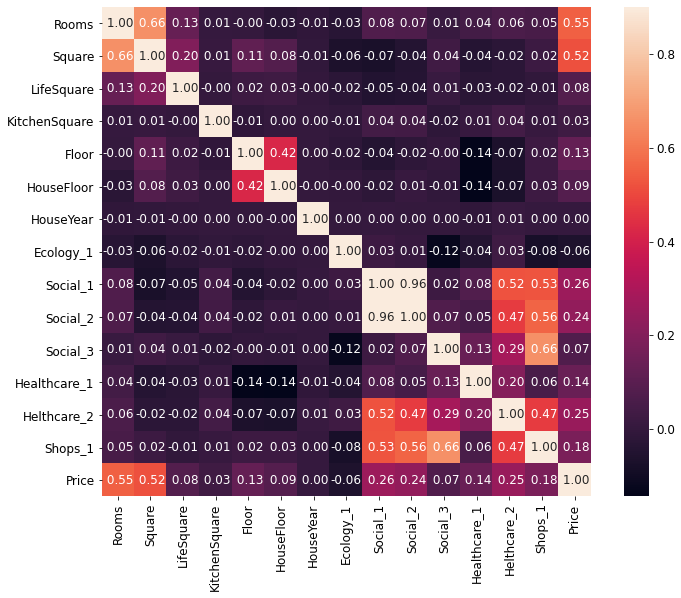

In [642]:
corrmat = train_df.corr()
ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, annot=True, fmt=' .2f', square=True);

Очень сильная зависимость двух признаков Social 1 и 2. Фактически 1 можно убрать

In [643]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])

for i in df_num_features:
    print('Количество уникальных значений признака ' + i + '\n')
    print(train_df[i].value_counts())

Количество уникальных значений признака Rooms

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64
Количество уникальных значений признака Square

52.327165    1
34.785487    1
45.823093    1
57.607965    1
57.925603    1
            ..
60.776683    1
72.956943    1
51.770111    1
41.843220    1
64.226361    1
Name: Square, Length: 10000, dtype: int64
Количество уникальных значений признака LifeSquare

20.151696    1
28.241964    1
23.884805    1
51.826876    1
47.972602    1
            ..
45.455722    1
50.458505    1
42.172028    1
21.993610    1
27.598712    1
Name: LifeSquare, Length: 7887, dtype: int64
Количество уникальных значений признака KitchenSquare

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        1

Обработка выбросов


Rooms - уберем нулевые и те, которые больше 5 и заменим их значением медианы  

In [644]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1 # оставляем метки по выбросам 
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()


2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

	KitchenSquare - есть как очень большие значения, так и слишком маленькие

In [645]:
(train_df['KitchenSquare'] > train_df['Square']).sum()

4

In [646]:
train_df['KitchenSquare'].quantile(.995), train_df['KitchenSquare'].quantile(.005) #в целом значение для кухни 20 метров можно считать нормальным, а 0 значения похожи на выброс

(20.0, 0.0)

In [647]:
ksq_sq = train_df['KitchenSquare'].median() / train_df['Square'].median() # соотношение площади кухни к площади квартиры

condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > 20) # значения больше 20 и нулевые будут заменены на медиану
train_df.loc[(train_df['KitchenSquare'] > train_df['Square']), 'KitchenSquare'] = ksq_sq * train_df['Square'] # если площадь кухни меньше площади жилья
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median() # значения больше 20 и нулевые будут заменены на медиану
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3 # значения меньше 3 будут заменены на 3

train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
5.0     1169
6.0     1086
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
16.0      16
20.0      14
17.0      12
19.0      11
18.0       6
Name: KitchenSquare, dtype: int64

LifeSquare - уберем пропуски и значения, где жилая площадь больше общей  

In [648]:
(train_df['LifeSquare'] > train_df['Square']).sum()

482

In [649]:
lsq_sq = train_df['LifeSquare'].median() / train_df['Square'].median() # соотношение жилой площади к площади квартиры

train_df.loc[(train_df['LifeSquare'] > train_df['Square']) | 
             (train_df['LifeSquare'].isna()), 'LifeSquare'] = lsq_sq * train_df['Square'] # заменим пустые значения и значения жилой площади, превышающие общую площадь
train_df['LifeSquare'].value_counts()

20.151696    1
33.588369    1
32.868850    1
33.191116    1
41.189016    1
            ..
24.262463    1
19.928799    1
21.836835    1
22.253046    1
27.598712    1
Name: LifeSquare, Length: 10000, dtype: int64

HouseFloor, Floor

In [650]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['HouseFloor'] > 50, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1 # проставим метку по выбросу/ошибке
train_df.loc[(train_df['Floor'] == 0), 'Floor'] = 1 # если значение 0, поставим 1 - предположим, что это одноэтажный дом
train_df.loc[train_df['HouseFloor'] > 50, 'HouseFloor'] = train_df['HouseFloor'].median() # слишком большие значения этажности заменим на медианные
train_df.loc[(train_df['HouseFloor'] == 0), 'HouseFloor'] = 1 # если значение 0, поставим 1 - предположим, что это одноэтажный дом
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'Floor'] = train_df['HouseFloor'] # если этаж "выше" дома, то предположим, что квартира на последнем этаже

In [651]:
train_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 36., 37., 38., 39., 40., 44., 45.,
       47., 48.])

In [652]:
train_df['Floor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       28., 31., 32., 33., 37., 42.])

HouseYear

In [653]:
now = datetime.now()
train_df.loc[(train_df['HouseYear'] > now.year), 'HouseYear'] = now.year #уберем значения больше текущего года
train_df['HouseYear'].sort_values().unique()


array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

Healthcare_1

In [654]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [655]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None

        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
      
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
             
        # KitchenSquare
        ksq_sq =  self.medians['KitchenSquare'] / self.medians['Square']
        X.loc[(X['KitchenSquare'] > X['Square']), 'KitchenSquare'] = ksq_sq * X['Square']
        
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > 20)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        
        # LifeSquare
        lsq_sq = self.medians['LifeSquare'] / self.medians['Square']
        X.loc[(X['LifeSquare'] > X['Square']) | 
             (X['LifeSquare'].isna()), 'LifeSquare'] = lsq_sq * X['Square']
    
            
        # HouseFloor, Floor
        
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > 50, 'HouseFloor_outlier'] = 1
        
        X.loc[(X['Floor'] == 0), 'Floor'] = 1
        X.loc[(X['HouseFloor'] == 0), 'HouseFloor'] = 1
        X.loc[(X['Floor'] > X['HouseFloor']), 'Floor'] = X['HouseFloor']
        X.loc[X['HouseFloor'] > 50, 'HouseFloor'] = self.medians['HouseFloor']

        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        X.fillna(self.medians, inplace=True)
        
        return X

# 3. Построение новых признаков 

In [656]:
binary_to_numbers = {'A': 0, 'B': 1} # перевод в бинарные признаки

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [657]:
# формирование нового признака - стоимость квартир в районе
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,MedPriceByDistrict
0,11809,27,3.0,115.027311,71.805419,10.0,4.0,10.0,2014,0.075424,...,11,3097,0,0,0,1,305018.871089,0,0,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,30,6207,1,1,0,1,177734.553407,0,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,33,5261,0,3,1,1,282078.720850,0,0,244005.272380
3,2352,1,1.0,40.409907,25.225751,3.0,10.0,22.0,1977,0.007122,...,1,264,0,0,1,1,168106.007630,0,0,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,33,8667,2,0,6,1,343995.102962,0,0,201584.441255


In [658]:
# формирование нового признака - размер района
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
train_df.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,MedPriceByDistrict,DistrictSize,IsDistrictLarge
0,11809,27,3.0,115.027311,71.805419,10.0,4.0,10.0,2014,0.075424,...,0,0,0,1,305018.871089,0,0,213530.788443,851,1
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,1,0,1,177734.553407,0,0,146032.829834,78,0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,3,1,1,282078.720850,0,0,244005.272380,652,1
3,2352,1,1.0,40.409907,25.225751,3.0,10.0,22.0,1977,0.007122,...,0,0,1,1,168106.007630,0,0,146735.671740,652,1
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,2,0,6,1,343995.102962,0,0,201584.441255,89,0


In [659]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
                
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
                
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
#            
                
        return X
   
   

In [660]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'MedPriceByDistrict',
 'DistrictSize',
 'IsDistrictLarge']

In [661]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'DistrictSize',
                     'IsDistrictLarge', 'new_district'] #'MedPriceByDistrict'- убрал, т.к. дает сильное переобучение

target_name = 'Price'

# 4.Разбиение на train и test

In [662]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

X = train_df.drop('Price', axis=1)
y = train_df['Price']

In [663]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [664]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

In [665]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 25), (3300, 25), (5000, 25))

In [666]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [667]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# 5.Построение модели

In [668]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.96
Test R2:	0.753


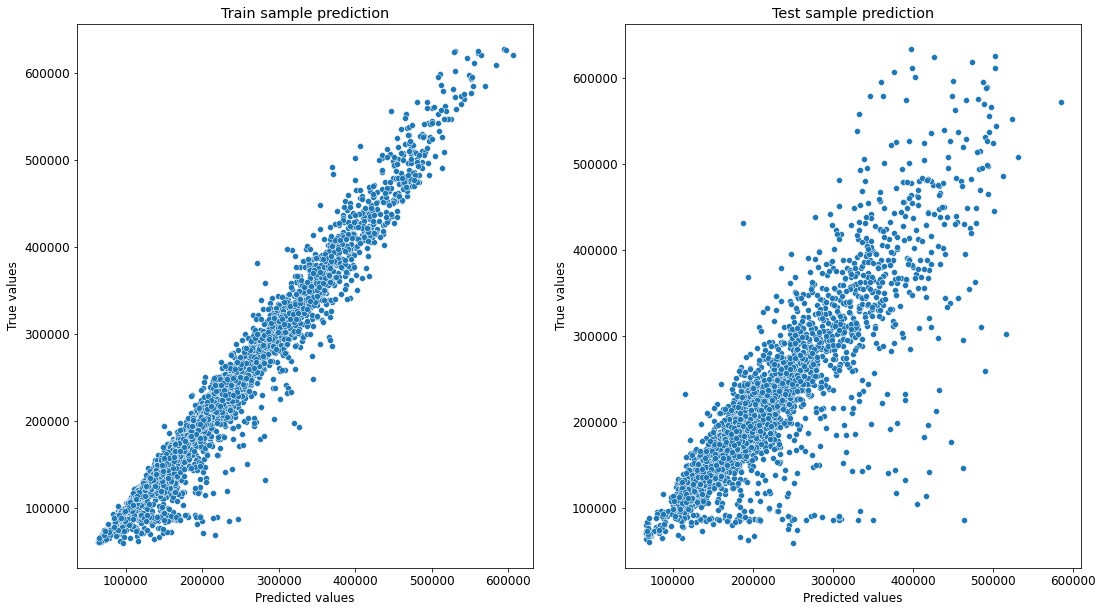

In [669]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [670]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72937224, 0.67181773, 0.70995438])

In [671]:
cv_score.mean()

0.7037147837357437

In [672]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.423651
18,DistrictSize,0.220416
12,Social_3,0.054190
6,HouseYear,0.037892
2,LifeSquare,0.036804
7,Ecology_1,0.036004
11,Social_2,0.033810
0,Rooms,0.029986
10,Social_1,0.026089
4,Floor,0.024315


In [673]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()
stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=21))],
                  final_estimator=GradientBoostingRegressor())

Train R2:	0.936
Test R2:	0.741


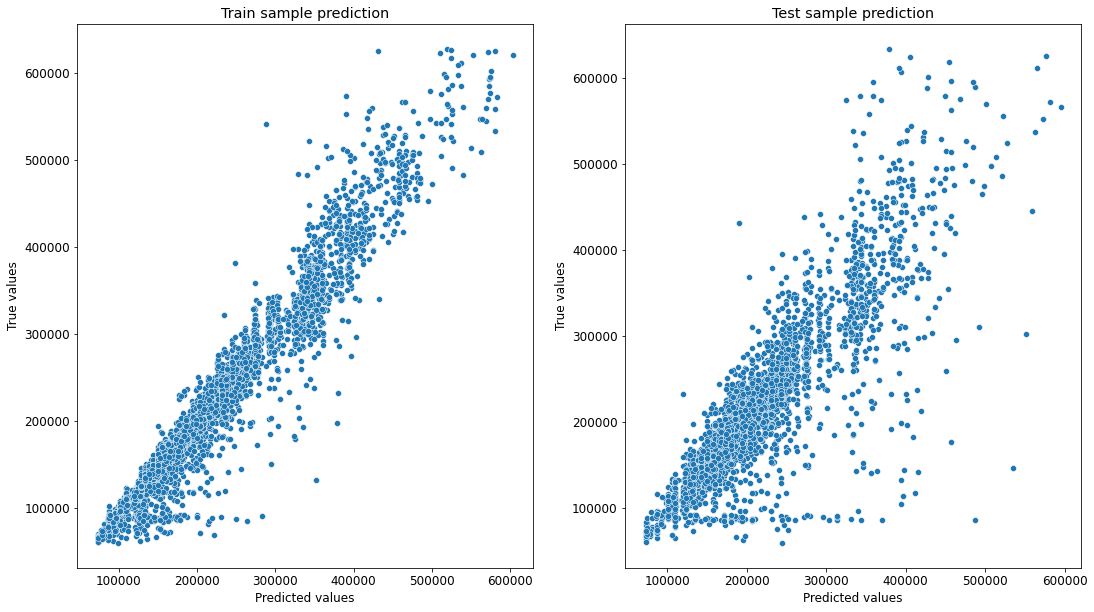

In [674]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# 6. Прогнозирование на тестовом датасете

In [675]:
test_df.shape

(5000, 21)

In [676]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [677]:
predictions = rf_model.predict(test_df)
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,153199.764272
1,5925,125770.784239
2,960,140921.417366
3,3848,136644.564186
4,746,197952.088952


In [ ]:
submit.to_csv('rf_submit.csv', index=False)